<a href="https://colab.research.google.com/github/KhaldounN/Weather-Prediction-/blob/master/FINAL_DSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!ip3 install flair

In [2]:
!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# Train Model to classify Emotions

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin 
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string
import spacy


In [4]:
#Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens
# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# This function will clean the text
def clean_text(text):     
    return text.strip().lower()
class predictors(TransformerMixin):

    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
# Create our list of punctuation marks
punctuations = string.punctuation

In [23]:
# We create our bag of words (bow) using our tokenizer and defining an ngram range
bow = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 

#initialize the model with 200 estimators parameter 
clf = RandomForestClassifier()

In [24]:
from sklearn.pipeline import Pipeline



pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow),
                 ('classifier', clf)], verbose=True)

In [25]:
### the below function was used to optimize the model and we reached that 200 estimators gives highest accuracy.

def Optimize_model(i):
  result = []
  for i in range(10,i,10):

    clf = RandomForestClassifier(n_estimators=i)
    pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow),
                 ('classifier', clf)], verbose=True)
    pipe.fit( X_train , y_train ) 
    sample_prediction = pipe.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, sample_prediction)
    result.append([i,accuracy])
    print('')
    print('')
    print('')
    print(i)
    print("Accuracy:",metrics.accuracy_score(y_test, sample_prediction))
    confusion_matrix = pd.crosstab(y_test, sample_prediction, rownames=['Actual'], colnames=['Predicted'])
    RandomForestClassifier

    print(confusion_matrix)
    sns.heatmap(confusion_matrix)
    plt.show()
  return result

In [26]:
# Import data . data from source was saparerated so I can to concatenate it 

import pandas as pd 
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('/content/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val = pd.read_csv('/content/val.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df = pd.concat([df_train,df_test, df_val])


#check data balance 
df['Sentiment'].value_counts()


joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Sentiment, dtype: int64

In [27]:
# split data for train and test 
X = df['Input']
ylabels = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [28]:

#Train Model
pipe.fit( X_train , y_train ) 

[Pipeline] ........... (step 1 of 3) Processing cleaner, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing vectorizer, total=   1.9s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  22.4s


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7f800f10a8d0>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_im

Accuracy: 0.87725
Predicted  anger  fear   joy  love  sadness  surprise
Actual                                               
anger        480     7    19     3       26         1
fear          22   357    10     2       35        32
joy           10    19  1208    58       39         5
love           3     2    64   264        2         0
sadness       40    18    27    10     1072         6
surprise       1    18     8     0        4       128


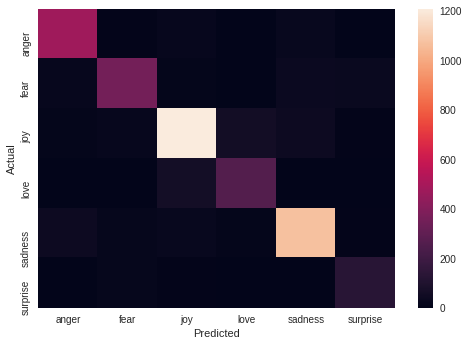

In [29]:
# Predicting with a test dataset
sample_prediction = pipe.predict(X_test)
from sklearn import metrics
import seaborn as sns
#test Accuracy :   
print("Accuracy:",metrics.accuracy_score(y_test, sample_prediction))
confusion_matrix = pd.crosstab(y_test, sample_prediction, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
sns.heatmap(confusion_matrix)

In [30]:
#save Model 

import pickle
filename = 'Randomforest_pipe.sav'
pickle.dump(pipe,open(filename, 'wb'))



In [31]:
filename = 'Randomforest_pipe.sav'

In [32]:
loaded_model = pickle.load(open(filename, 'rb'))


In [35]:
s = ' I hate you '

In [36]:
loaded_model.predict(s)

array(['joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy',
       'joy', 'joy', 'joy'], dtype=object)

In [15]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import math

# Defining Functions 

In [ ]:

# load book , clean data and split into sentences 
def Load_book(path):
  book = open(path, 'r').read()
  book = book.replace("\n",'')
  sentences  = book.split('.')

  return sentences 

# run sentiment analysis on each sentence in the book and save them into df_setiment 
def Analyzse_sentiment(sentences):
  tagger = TextClassifier.load('sentiment')
  df_sentiment = pd.DataFrame((np.zeros((4,int(len(sentences))))))
  for i, sentence in enumerate(sentences):
    sentence = Sentence(sentence)
    tagger.predict(sentence)
    df_sentiment[i].update(sentence.labels)


  for i , sentence in enumerate(df_sentiment.iloc[0,:]):
      try:
        df_sentiment.iloc[1,i] = sentence.value
        if sentence.value == 'NEGATIVE':
          df_sentiment.iloc[2,i] = sentence.score * (-1)
        else:
          df_sentiment.iloc[2,i] = sentence.score
      except:
        pass

  return df_sentiment


# calcualte Major and Minor sentiment and vizualize it in a dashabord style

def Display_sentiment(df_sentiment  , booktitle = ' book title'):

  l = df_sentiment.iloc[2,:]
  l = pd.DataFrame(l) 
  l['Major'] = l.iloc[:,0].rolling(40).mean()
  l['Minor'] = l.iloc[:,0].rolling(10).mean()

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
  axes[0].set_title(booktitle , fontsize = 30 )
  axes[0].plot(l['Major'])
  axes[0].set_xlabel('Sentences' , fontsize=20)
  axes[0].set_ylabel('Sentiment', fontsize=20)
  axes[0].legend(['Major Sentiment(rolling average for 30 sentences)'], fontsize=20)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[0].set_facecolor('aliceblue')
  axes[1].plot(l['Minor'])
  axes[1].set_xlabel('Sentences' , fontsize=15)
  axes[1].set_ylabel('Sentiment' , fontsize=15)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[1].set_facecolor('aliceblue')
  axes[1].legend(['Minor Sentiment(rolling average for 5 sentences)'] , fontsize=20)

def Analyzse_emotions(sentences):
  filename = 'Randomforest_model.sav'
  clf = pickle.load(open(filename, 'rb'))
  for i in 


  

In [ ]:
Analyzse_emotions(df)

In [ ]:

s = 'I hate you  '

filename = 'Randomforest_model.sav'
pipe = pickle.load(open(filename, 'rb'))
f = pipe.predict(s)

print(f)

In [ ]:
 sentences = Load_book('/content/Beyond good and Evil.txt')
 sentences = sentences[

In [ ]:
#df = Analyzse_sentiment(sentences)
Display_sentiment(df)